In [1]:
import chardet
import string 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

### Load Twitter dataset after determining character encoding

In [3]:
# get character encoding 
def find_encoding(fname: str) -> str:
    with open(fname, 'rb') as file: 
        r_file = file.read()
        result = chardet.detect(r_file)
        charenc = result['encoding']
    return charenc

In [4]:
find_encoding("./Sentiment Analysis Dataset.csv")

'UTF-8-SIG'

In [5]:
# read csv file 
filepath = "./Sentiment Analysis Dataset.csv"
corpus = pd.read_csv(filepath, sep=",", 
                     error_bad_lines=False, 
                     header=0,  
                     encoding='UTF-8-SIG')
corpus.head()

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [6]:
corpus.shape

(1578612, 4)

In [7]:
corpus.dtypes

ItemID              int64
Sentiment           int64
SentimentSource    object
SentimentText      object
dtype: object

In [8]:
# check unique items in predictors 
print(corpus.Sentiment.unique())
print(corpus.SentimentSource.unique())

[0 1]
['Sentiment140' 'Kaggle']


In [9]:
# pre-process data: drop id column
corpus.drop(columns="ItemID", inplace=True)

In [10]:
# check for duplicate rows
corpus.duplicated().sum()

0

In [11]:
# rename features
mapper = {"Sentiment": "sentiment", 
          "SentimentSource": "source", 
          "SentimentText": "tweet_text"}
corpus.rename(mapper=mapper, axis=1, inplace=True)

In [12]:
corpus.head()

,sentiment,source,tweet_text
0,0,Sentiment140,is so sad for my APL frie...
1,0,Sentiment140,I missed the New Moon trail...
2,1,Sentiment140,omg its already 7:30 :O
3,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [13]:
# inspect first n tweets 
# (randomly sampled from the whole dataset)
def print_first_n_tweets(n=10): 
    ''' 
    Randomly samples and prints up to 5,000 tweets from the corpus. 
    '''
    
    if n >= 5000: return "Less than 5000 tweets please!"
    rsample = corpus["tweet_text"].sample(n=5000, random_state=1987)
    
    print(115*"-")
    for i in range(n): 
        print('{:>8}  {:>3}  {}'.format(rsample.index[i], "-->", rsample.iloc[i][:90]))
    print(115*"-")

In [14]:
print_first_n_tweets(n=50)

-------------------------------------------------------------------------------------------------------------------
  399805  -->  @robbiespeaks I like it man  you write the lyrics &amp; I'll get our band to rock it out!!
  885122  -->  I'm gonna take a short nap.. I almost in giving out thumbs, which sucks big time coz I'm i
 1301910  -->  watching Cool Center right.  i missed their episode when Eugene got an interviewed with @D
  441097  -->  @Snyper11 It may all be over now!! I was enjoying that 
 1560070  -->  wants someone to sleep over  and on myspace... as usall
  341421  -->  @NEENZ I was just at Sky Harbor on Friday.    How are you?
   38006  -->  @amberamputee  oh noes
 1081784  -->  My friends know me well. I got perfect birthday presents. Thanks to those who showed up at
 1269257  -->  Too bad everyday can't be a Follow Friday...what are we supposed to do on Saturdays?  
  613813  -->  at home, hungry.... 
  394976  -->  @revmem Oh, me neither. I'm sure it would've been eve

In [15]:
# tweet length distribution
tweet_length = corpus["tweet_text"].apply(lambda x: len(x))

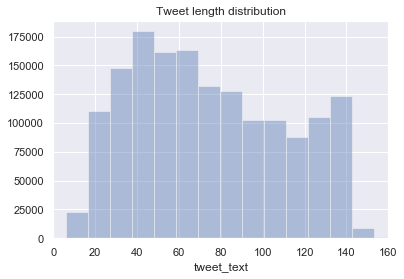

In [16]:
ax = sns.distplot(tweet_length, bins= 35, kde= False)
ax = plt.xlim(0, 160)
ax = plt.title("Tweet length distribution")

A few tweets are longer than the 140 characters limit probably because they contain text-converted emojis. 

### Clean documents

Cleaning the tweets will recover some potentially important information from wrongly decoded symbols and words, and will make the dataset vocabulary smaller for a simpler model. 

* Fix encoding-decoding issues (e.g. ``&lt;`` is html coding for symbol <). 
* Remove web urls. 
* Remove all numbers, twitter users' hashes and references. 
* Lowercase all letters. 
* Remove stopwords and punctuation.
* Tokenize tweets and build vocabulary.

In [17]:
# clean tweets: 
# checks if there is residual html code for < symbols
print(corpus["tweet_text"].apply(lambda x: "&lt;" in x).sum())
# checks if there is residual html code for " symbols
print(corpus["tweet_text"].apply(lambda x: "&quot;" in x).sum())
# checks for wrongly interpreted unicode characters
print(corpus["tweet_text"].apply(lambda x: "â" in x or "à" in x or "ã" in x).sum())

16824
33788
4297


Encoding-decoding problems in text are frequent, e.g. character â€™ is quote ' in Windows-1252 encoding which was mistakenly decoded as UTF-8. Thousands of tweets contain text with such errors. ``fix-text-for-you`` library comes in handy to fix most of these issues. 

In [18]:
# fix UTF-8 encoding-decoding problems 
import ftfy 

``ftfy.fix_text()`` takes care of:   
* fixing html stuff 
* correctly restoring UTF-8 representation of characters 

In [19]:
corpus["tweet_text"] = corpus["tweet_text"].apply(ftfy.fix_text)

After this operation is performed, the unicode object replacement character "ï¿½" used for unrecognizable stuff (symbols that couldn't be recovered) has been converted to �. 

In [20]:
# example using tweet in row 455
ustring = corpus["tweet_text"][455]
print(ustring, "\n")
# --> Unicode code point - representation - name 
ftfy.explain_unicode(ustring[20])

 - My name is Amy. I�m only three My eyes are swollen I cannot see, I must be stupid, I must be bad What... http://tumblr.com/xfj1uain0 

U+FFFD  �       [So] REPLACEMENT CHARACTER


In [21]:
# fix this here with built-in string replacement function
# '\ufffd'is unicode for object replacement symbol 
corpus["tweet_text"] = corpus["tweet_text"].apply(lambda x: x.replace('\ufffd', '?'))

In [22]:
# checks if there is residual html code for < symbols
print(corpus["tweet_text"].apply(lambda x: "&lt;" in x).sum())
# checks if there is residual html code for " symbols
print(corpus["tweet_text"].apply(lambda x: "&quot;" in x).sum())
# checks for wrongly interpreted unicode characters
print(corpus["tweet_text"].apply(lambda x: "â" in x or "à" in x or "ã" in x).sum())
# corpus size
print(corpus.shape)

0
0
1848
(1578612, 3)


In [23]:
# tweets containing urls 
print(corpus["tweet_text"].apply(lambda x: "http" in x).sum())

68891


In [24]:
# remove urls 
# search for regex containing "http" followed by anything but a whitespace,  
# replace with empty string
corpus["tweet_text"] = corpus["tweet_text"].apply(lambda x: re.sub(r"http\S+", "", x))
# tweets containing urls 
print(corpus["tweet_text"].apply(lambda x: "http" in x).sum())

17


In [25]:
# tweets contaning user handles 
pattern = re.compile("@\S+")
print(corpus["tweet_text"].apply(lambda x: 0 if not pattern.search(x) else 1).sum())

736093


In [26]:
# remove users' handles  
# @ : matches any substring from character @
# \S+ : until one or more whitespaces are detected 
corpus["tweet_text"] = corpus["tweet_text"].apply(lambda x: re.sub(r"@\S+", "", x))

# all handles removed
print(corpus["tweet_text"].apply(lambda x: 0 if not pattern.search(x) else 1).sum())

0


In order to make the vocabulary smaller, other symbols that are not ASCII characters can be removed. This can however remove symbols that carry substantial emotional meaning and would aid the classification of the tweets. 

In [27]:
# decrease size of vocabulary 
# remove all words that contain characters 
# not included in ASCII range from space to tilde 
# example
ustring = corpus["tweet_text"][2564]
print(ustring)
# symbols like this add information about emotion in the tweet, 
# they are removed to decrease the complexity of the model 

 i dont like the fact my gay best friend is in tears... ♥


In [28]:
# [^ -~] : matches anything that is not ASCII character included in range from space to tilde 
print(re.sub(r"[^ -~]", "", ustring))

 i dont like the fact my gay best friend is in tears... 


In [29]:
corpus["tweet_text"] = corpus["tweet_text"].apply(lambda x: re.sub(r"[^ -~]", "", x))

In [30]:
# remove all hashtags 
corpus["tweet_text"] = corpus["tweet_text"].apply(lambda x: re.sub(r"#\S+", " ", x))

# further decrease size of vocabulary:
# remove all non-alphabetic characters (i.e. not letters)
corpus["tweet_text"] = corpus["tweet_text"].apply(lambda x: re.sub(r"[^ a-zA-Z]", " ", x))

In [31]:
# lowercase all
corpus["tweet_text"] = corpus["tweet_text"].apply(lambda x: x.lower())

In [32]:
print_first_n_tweets(n=1000)

-------------------------------------------------------------------------------------------------------------------
  399805  -->   i like it man  you write the lyrics   i ll get our band to rock it out  
  885122  -->  i m gonna take a short nap   i almost in giving out thumbs  which sucks big time coz i m i
 1301910  -->  watching cool center right   i missed their episode when eugene got an interviewed with  o
  441097  -->   it may all be over now   i was enjoying that 
 1560070  -->  wants someone to sleep over  and on myspace    as usall
  341421  -->   i was just at sky harbor on friday     how are you 
   38006  -->    oh noes
 1081784  -->  my friends know me well  i got perfect birthday presents  thanks to those who showed up at
 1269257  -->  too bad everyday can t be a follow friday   what are we supposed to do on saturdays   
  613813  -->  at home  hungry     
  394976  -->   oh  me neither  i m sure it would ve been even that much better if i were a graphic desig
 121720

Define function that builds list of words and word frequencies with ``nltk`` library for language processing. 

In [33]:
# get stopwords 
from nltk import download
download("stopwords")
# list of stopwords 
from nltk.corpus import stopwords
# tokenize tweets
from nltk.tokenize import wordpunct_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Giacomo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
def make_tokens(txt: pd.Series) -> (pd.Series, pd.Series): 
    '''
    Input: pandas series with one tweet per row. 
    Output: tuple with 1. pandas series with one word per row. 
                       2. pandas series with word frequencies. 
    '''
    
    if isinstance(txt, pd.Series) and txt.dtype=="object": 
    
        words = list()
        # loop over tweets: one per row 
        for tw in txt: 
            # tokenize and add to list of tokens
            words += wordpunct_tokenize(tw)
    else: 
        return "Wrong input type or dtype."
    
    words = pd.Series(words)
    freq = words.value_counts(sort=True)
    
    # return tuple with tokens and word frequencies
    return (words, freq)

Split corpus into two datasets with positive and negative tweets only. 

In [35]:
# positive tweets 
pos_tweets = corpus[ corpus["sentiment"]==1 ].tweet_text
# negative tweets 
neg_tweets = corpus[ corpus["sentiment"]==0 ].tweet_text

In [36]:
# balanced classes? 
print(len(pos_tweets))
print(len(neg_tweets))

790177
788435


The two classes are balanced; this information will be useful when measuring the performance of the classifier. Accuracy and Kappa scores will suffice. 

Builds list of words used in positive and negative tweets along with their respective frequencies. 

In [37]:
# list of words in positive tweets 
(pos_words, freq_pos_words) = make_tokens(pos_tweets)
# list of words in negative tweets 
(neg_words, freq_neg_words) = make_tokens(neg_tweets)
print("Tokens in pos tweets: ", len(pos_words))
print("Tokens in neg tweets: ", len(neg_words))

Tokens in pos tweets:  9760762
Tokens in neg tweets:  10689190


In [38]:
# do not consider stopwords
print(stopwords.words("English")[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


#### Top 10 most frequently used words in positive tweets 

In [39]:
freq_pos_words[ ~freq_pos_words.index.isin(stopwords.words("English")) ].head(10)

good      60777
love      47567
day       46833
like      37452
get       36239
lol       35976
thanks    34419
u         31856
going     30550
time      30066
dtype: int64

#### Top 10 most frequently used words in negative tweets 

In [40]:
freq_neg_words[ ~freq_neg_words.index.isin(stopwords.words("English")) ].head(10)

get       45502
go        45168
work      44023
day       40928
like      40887
today     37860
going     33423
got       33149
back      32618
really    31181
dtype: int64

#### Top 10 most frequently used words: bar chart

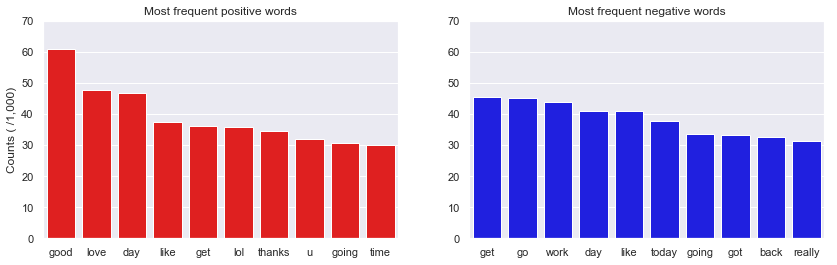

In [41]:
# display most frequent words in a bar chart 
mfpw = freq_pos_words[ ~freq_pos_words.index.isin(stopwords.words("English")) ][:10]
mfnw = freq_neg_words[ ~freq_neg_words.index.isin(stopwords.words("English")) ][:10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

plt.subplot(121)
ax1 = sns.barplot(x= mfpw.index, y= mfpw/1e3, color="red")
ax1 = plt.title("Most frequent positive words")
ax1 = plt.ylabel("Counts ( /1,000)")
ax1 = plt.ylim(0, 70)

plt.subplot(122)
ax2 = sns.barplot(x= mfnw.index, y= mfnw/1e3, color="blue")
ax2 = plt.title("Most frequent negative words")
ax2 = plt.ylim(0, 70)

### Zipf's Law

Word frequency and ranking in frequency table are inversely proportional: 

$$\large f \times r \approx const. $$   

where $f$ is the word frequency and $r$ is its ranking. 

Check Zipf's Law using entire dataset (including stop words in English). 

In [42]:
# construct frequency table from the whole dataset
(corpus_words, freq) = make_tokens(corpus.tweet_text)
freq.head()

i      951682
to     561546
the    521775
a      380790
my     313941
dtype: int64

In [43]:
df = freq.to_frame(name= "freq")
# add column with word rank
df["rank"] = range(df.shape[0])
df["rank"] = df["rank"].apply(lambda x: x+1)
# add word column from index 
df.reset_index(inplace=True)
df.rename(mapper={"index": "word"}, inplace=True, axis= "columns")
# add column with Zipf's value (freq x rank)
df["zipf_value"] = df["freq"]*df["rank"]
df.head()

,word,freq,rank,zipf_value
0,i,951682,1,951682
1,to,561546,2,1123092
2,the,521775,3,1565325
3,a,380790,4,1523160
4,my,313941,5,1569705


In [44]:
def plot_zipf_value(n=100): 
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax = plt.plot("word", "zipf_value", data=df[:n], linestyle='-') # , marker='o')
    ax = plt.ylim(0, 5e6)
    ax = plt.ylabel("Freq. x Rank")
    ax = plt.xticks("Word Axis")
    ax = plt.title("Checking Zipf's Law: Freq x Rank ~ const.")

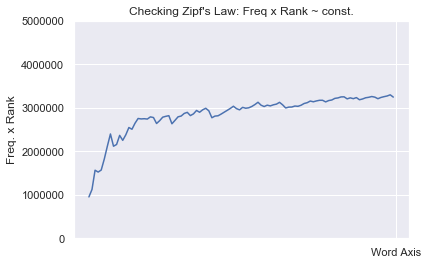

In [45]:
plot_zipf_value(n=100)

Check Zipf's Law after removing stop words. 

In [46]:
# without stopwords
df = df[ ~df["word"].isin(stopwords.words("English")) ]
# df = df.reset_index(drop=True)
df["rank"] = range(df.shape[0])
df["rank"] = df["rank"].apply(lambda x: x+1)
df.head()

,word,freq,rank,zipf_value
31,good,89731,1,2871392
32,day,87761,2,2896113
34,get,81741,3,2860935
36,like,78339,4,2898543
39,go,73297,5,2931880


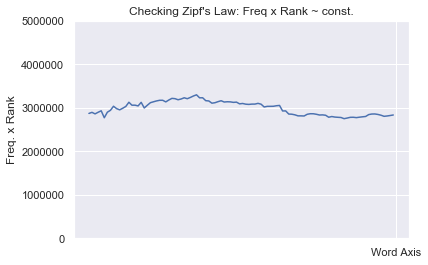

In [47]:
plot_zipf_value(n=100)

### Asymptotic trend of Frequency vs. Rank

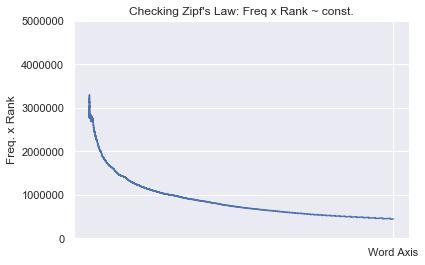

In [48]:
plot_zipf_value(n=20000)

Word axis is just rank $r$ shifted by one unit: ``df.index``$ = r - 1$. <br>
As we scroll down the frequency table, the frequency starts to decrease less than the rank increases. The linear relationship between $f$ and $1/r$ does not hold any longer. <br>

So it looks like Zipf's Law is not asymptotically valid (at least for large corpora for which ``len(corpus) >> 100``). <br> 
The product $f \times r$ is dominated by the rank factor: 

$$\large f \times r \approx r - 1 , \space \text{as} \space\space r \rightarrow \infty $$

$$\large f \approx 1 - 1/r $$

In [49]:
# asymptotic value of frequency
df["f_asympt"] = 1 - 1/df["rank"]
df.head()

,word,freq,rank,zipf_value,f_asympt
31,good,89731,1,2871392,0.000000
32,day,87761,2,2896113,0.500000
34,get,81741,3,2860935,0.666667
36,like,78339,4,2898543,0.750000
39,go,73297,5,2931880,0.800000


In [50]:
def plot_asympt(n=5000): 
    fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(14, 4))
    plt.subplots_adjust(wspace= 0.4)
    
    # plot Zipf's product 
    plt.subplot(121)
    ax_1 = plt.plot("word", "zipf_value", data=df[:n], linestyle='-') # , marker='o')
    ax_1 = plt.ylim(0, 5e6)
    ax_1 = plt.ylabel("Freq. x Rank")
    ax_1 = plt.xticks("Word Axis")
    ax_1 = plt.title("Checking Zipf's Law: Freq x Rank ~ const.")
    
    # plot f ~ (1 - 1/r): asymptotic value of frequency
    plt.subplot(122)
    ax_2 = plt.plot("rank", "f_asympt", data=df.loc[100:2000, :], linestyle='-', color= "orange")
    ax_2 = plt.ylim(0.5, 1.5)
    ax_2 = plt.ylabel("Frequency")
    ax_2 = plt.xlabel("Rank")
    ax_2 = plt.title("frequency vs. 1 - 1/rank\nFrom 100th to 2,000th")

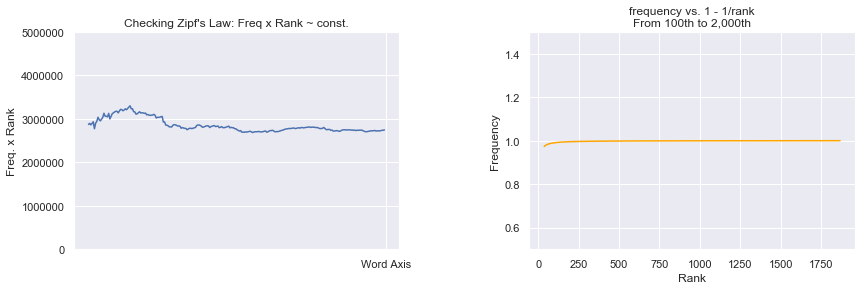

In [51]:
plot_asympt(n=250)

### Simple classifier to predict tweet sentiment: Bernoulli Naive Bayes

A "Bag of Words" approach coupled with a Naive Bayes classifier is used to build a simple model that predicts tweet sentiment. <br> 

1. Each tweet is converted to a list of words. <br>
2. Each different word becomes a feature of the dataset. The total number of features is equal to the total number of different words in the dataset. <br>
3. The features take on values that depend on the selected model: I have chosen a Naive Bayes Bernoulli classifier to keep the model simple and fast to train. In this model, each feature can be either 1 (the word is present in the tweet) or 0 (the word does not appear in the tweet). <br>  
4. Features are assumed to be mutually independent, i.e. the presence/absence of a word in a tweet does not affect the distribution of other words. <br>
4. The classifier predicts the sentiment of a tweet in the test set by calculating the probability that it belongs to each one of the two classes, given its features and the feature conditional probabilities from the train set. The tweet is assigned to the class with higher probability. 

The feature dataset is constructed with the ``sklearn`` library which provides an efficient data structure to handle large sparse matrices as well as an off-shelf Naive Bayes classifier.

In [52]:
corpus.drop("source", axis=1, inplace=True)
corpus.head()

,sentiment,tweet_text
0,0,is so sad for my apl frie...
1,0,i missed the new moon trail...
2,1,omg its already o
3,0,omgaga im sooo im gunna cry i ...
4,0,i think mi bf is cheating on me ...


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

In [54]:
# split data into train and test set 
c_train, c_test = train_test_split(corpus, test_size= 0.2, random_state=1987)
print(c_test.shape)
print(c_train.shape)

(315723, 2)
(1262889, 2)


``CountVectorizer`` transforms the data frame into a sparse matrix whose columns store the counts of each different word in the corpus (up to a maximum word number equal to ``max_features``). Each row represents an observation, i.e. a tokenized tweet. 

In [55]:
tokenizer = CountVectorizer(stop_words="english",  # remove stopwords
                            encoding="utf8",        
                            max_features=1000)     # consider only first 1,000 words, 
                                                   # based on frequency

In [56]:
# tokenize tweets and build sparse matrix storing word counts 
fmatrix_train = tokenizer.fit_transform(c_train["tweet_text"])
fmatrix_test = tokenizer.transform(c_test["tweet_text"])

Naive Bayes Bernoulli classifier will: 
* automatically binarize word counts: for each word, its count is set to 1 if word is in tweet, 0 otherwise. 
* when calculating class probabilities for a new tweet in the test set, the classifier will consider all words in the dataset vocabulary, including those that do not appear in that tweet. 

In [57]:
# instantiate Naive Bayes Bernoulli classifier
model = BernoulliNB()

The model can be evaluated first using subsets of the test set to check if it is statistically robust against variations in the train data (i.e., if its variance is low). Given that the Twitter dataset is large, the conditional distribution of the most frequent words should not change over randomly sampled cross-validation subsets. Hence, the accuracy should vary little over the cross-validation subsets. 

In [58]:
from sklearn.model_selection import RepeatedKFold, cross_validate

In [59]:
# evaluate model performance on subsets of train set 
# using 10-fold repeated CV 
# cv generator: 10-fold CV repeated twice
rkf= RepeatedKFold(n_splits= 10, 
                   n_repeats= 2, 
                   random_state= 1987)

# classifier performance: area under ROC, accuracy 
scoring= ["roc_auc", "accuracy"]

# train and calculate metrics for each validation iteration  
scores = cross_validate(model, 
                        fmatrix_train, 
                        c_train["sentiment"], 
                        scoring= scoring, 
                        cv= rkf, 
                        n_jobs= 4, 
                        return_train_score= False, 
                        return_estimator= False)

In [60]:
# accuracy is consistent over the cv folds  
print(scores["test_accuracy"])

[0.73535304 0.73415737 0.73388023 0.73396733 0.733999   0.73358725
 0.7333497  0.73623198 0.73452953 0.73390979 0.73437116 0.73512341
 0.73417321 0.733223   0.7340861  0.73263705 0.73559059 0.73500463
 0.73372186 0.73582605]


Finally, the model is trained using the whole training set. A new tweet from the test set will be assigned to class: 

$$ \large \hat c = \arg \max \Bigg \{ \text{Pr} (c_{1}) \prod_{i=1}^{N} \text{Pr}(w_{i}|c_{1}), \space \text{Pr} (c_{2}) \prod_{i=1}^{N} \text{Pr}(w_{i}|c_{2}) \Bigg \}$$   

where: <br> 
* $w_{i}$ is a feature (word) of the dataset ($i=1,...,N$): $w_{i}=1 \space \text{or} \space 0$ 
* $\text{Pr}(w_{i}|c)$ is the probability of observing word $w_{i}$ considering only the tweets of class $c$ ($c_{1}=\text{positive}, \space c_{2}=\text{negative}$) in the training set, 
* $\text{Pr}(c)$ is the probability that a randomly selected tweet from the training set belongs to class $c$. 

In [61]:
# train model using whole train set 
model.fit(fmatrix_train, c_train["sentiment"])

# predict sentiment of tweets in test set (20% of total)
sent_pred = model.predict(fmatrix_test)

acc = accuracy_score(c_test["sentiment"], sent_pred)
print("Model accuracy: {:.3f}".format(acc))

Model accuracy: 0.734


It is interesting to look at the accuracy trend as a function of the number of important (most frequent) words considered when training the model. The previous steps can be wrapped into a ``for`` loop over the number of important words ``max_features``. 

In [62]:
acc = dict()
for max_features in (100, 500, 1000, 5000, 10000, 50000): 

    tokenizer = CountVectorizer(stop_words="english",
                                encoding="utf8",        
                                max_features=max_features)     # consider only first max_feature words
    
    # make feature matrices 
    fmatrix_train = tokenizer.fit_transform(c_train["tweet_text"])
    fmatrix_test = tokenizer.transform(c_test["tweet_text"])
    
    # train model using whole train set 
    model.fit(fmatrix_train, c_train["sentiment"])
    # predict sentiment of tweets in test set
    sent_pred = model.predict(fmatrix_test)
    # store accuracy in dict
    acc[max_features] = accuracy_score(c_test["sentiment"], sent_pred)
    print("Model accuracy: {:.3f}".format(acc[max_features]))

Model accuracy: 0.643
Model accuracy: 0.713
Model accuracy: 0.734
Model accuracy: 0.759
Model accuracy: 0.763
Model accuracy: 0.767


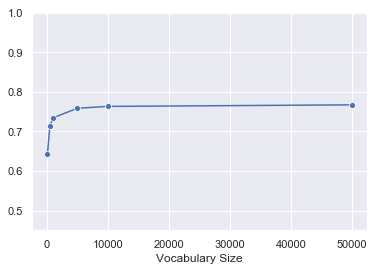

In [63]:
ax = sns.lineplot(x= [k for k in acc.keys()], 
                  y= [v for v in acc.values()], 
                  marker="o")
ax = plt.ylim(0.45, 1.0)
ax = plt.xlabel("Vocabulary Size")

Possible improvements include:   

* Considering more and better features to construct the bag of words by: 
    * using a gentler pre-processing of tweets that keeps text-converted emojis and other symbols which enrich sentences with emotional meaning. 
    * adding n-gram expressions to the list of features, i.e. groups of adjacent words with special significance for the emotional content of the tweet. 
* Replacing the simple 0/1 binarization of word counts with other scores such as tf-idf to be used with a different classifier (e.g. Naive Bayes multinomial). 

Generally, any model that considers the context in which words are used, and uses it to group similar words, should perform better than the bag-of-words approach. In particular, techniques such as word embedding (representing words as vectors instead of scalars) coupled to neural networks seem to be the current state-of-the-art methods for text classification. 